In [4]:
from sklearn.model_selection import train_test_split, learning_curve, StratifiedKFold
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df_train_model = pd.read_csv('df_sentiment_embeddings.csv')

In [6]:

# Prepare data for XGBoost
X = df_train_model.drop(columns='sentiment')  # Features (Word2Vec representations)
y = df_train_model['sentiment']  # Labels


# Mapping labels from [-1, 0, 1] to [0, 1, 2]
# 0 = negative review
# 1 = neutral review
# 2 = positive review
class_mapping = {-1: 0, 0: 1, 1: 2}
y = y.map(class_mapping)



# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set hyperparameters
params = {
    'booster': 'gbtree',
    'objective': 'multi:softmax',
    'max_depth': 5,
    'learning_rate': 0.03,
    'n_estimators': 600,
    'subsample': 0.4,
    'colsample_bytree': 0.5,
    'lambda': 0.1,
    'num_class':3,
}

# Create the XGBoost classifier
model = xgb.XGBClassifier(**params)

# Train the model with evaluation on a validation set
model.fit(X_train, y_train, eval_set=[(X_test, y_test)],  eval_metric='mlogloss', verbose=True)



c:\Users\hsohr\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:1.09072
[1]	validation_0-mlogloss:1.08361
[2]	validation_0-mlogloss:1.07636
[3]	validation_0-mlogloss:1.06959
[4]	validation_0-mlogloss:1.06263
[5]	validation_0-mlogloss:1.05590
[6]	validation_0-mlogloss:1.05033
[7]	validation_0-mlogloss:1.04424
[8]	validation_0-mlogloss:1.03847
[9]	validation_0-mlogloss:1.03291
[10]	validation_0-mlogloss:1.02773
[11]	validation_0-mlogloss:1.02289
[12]	validation_0-mlogloss:1.01771
[13]	validation_0-mlogloss:1.01299
[14]	validation_0-mlogloss:1.00874
[15]	validation_0-mlogloss:1.00434
[16]	validation_0-mlogloss:0.99997
[17]	validation_0-mlogloss:0.99546
[18]	validation_0-mlogloss:0.99103
[19]	validation_0-mlogloss:0.98718
[20]	validation_0-mlogloss:0.98339
[21]	validation_0-mlogloss:0.97960
[22]	validation_0-mlogloss:0.97568
[23]	validation_0-mlogloss:0.97218
[24]	validation_0-mlogloss:0.96861
[25]	validation_0-mlogloss:0.96530
[26]	validation_0-mlogloss:0.96222
[27]	validation_0-mlogloss:0.95916
[28]	validation_0-mlogloss:0.9

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.1, learning_rate=0.03,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=600, n_jobs=None, num_class=3, ...)

In [7]:
from sklearn.metrics import accuracy_score

def plot_learning_curve_with_accuracy(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy')
    
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.grid()

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.legend(loc="best")

    # Calculate accuracy scores
    accuracy_cv = [accuracy_score(y, estimator.predict(X)) for _ in range(len(train_sizes))]
    best_accuracy = max(accuracy_cv)
    print("Best Accuracy - Cross Validation Set:", best_accuracy)
    
    return plt, best_accuracy



Best Accuracy - Cross Validation Set: 0.7799953853253345


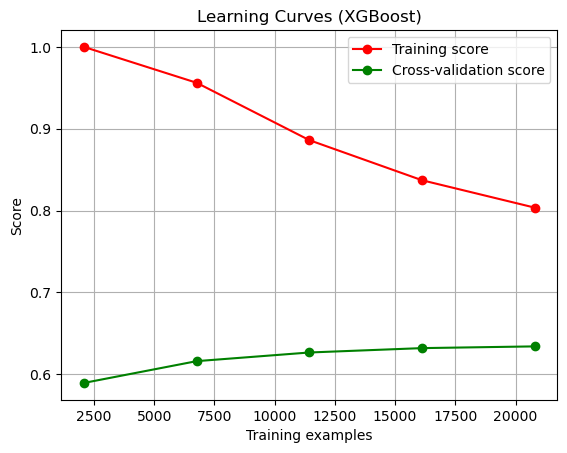

Best Accuracy: 0.7799953853253345


In [8]:
# Define the Stratified K-Fold cross-validator
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Plot learning curve
title = "Learning Curves (XGBoost)"
plot, best_accuracy = plot_learning_curve_with_accuracy(model, title, X_train, y_train, cv=cv, n_jobs=-1)
plot.show()


print("Best Accuracy:", best_accuracy)



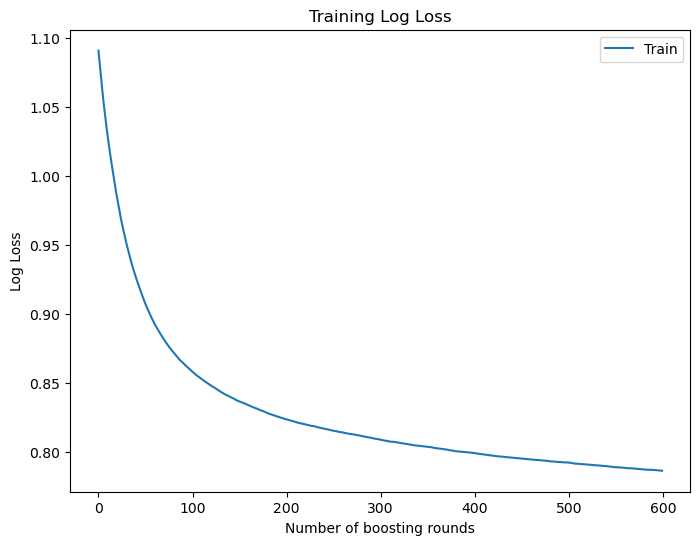

In [9]:
# Plotting the cost function (evaluation metric)
results = model.evals_result()
train_error = results['validation_0']['mlogloss']
x_axis = range(len(train_error))

plt.figure(figsize=(8, 6))
plt.plot(x_axis, train_error, label='Train')
plt.xlabel('Number of boosting rounds')
plt.ylabel('Log Loss')
plt.title('Training Log Loss')
plt.legend()
plt.show()

In [10]:
# Predict on the test dataset using cross-validation
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy on the training dataset :", accuracy_train)
print("Accuracy on the test dataset :", accuracy_test)


# Calculate precision and recall scores
precision = precision_score(y_test, y_pred_test, average='weighted')  # 'weighted' accounts for class imbalance
recall = recall_score(y_test, y_pred_test, average='weighted')  # 'weighted' accounts for class imbalance

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

Accuracy on the training dataset : 0.7799953853253345
Accuracy on the test dataset : 0.6302107368097216
Precision: 0.6243
Recall: 0.6302


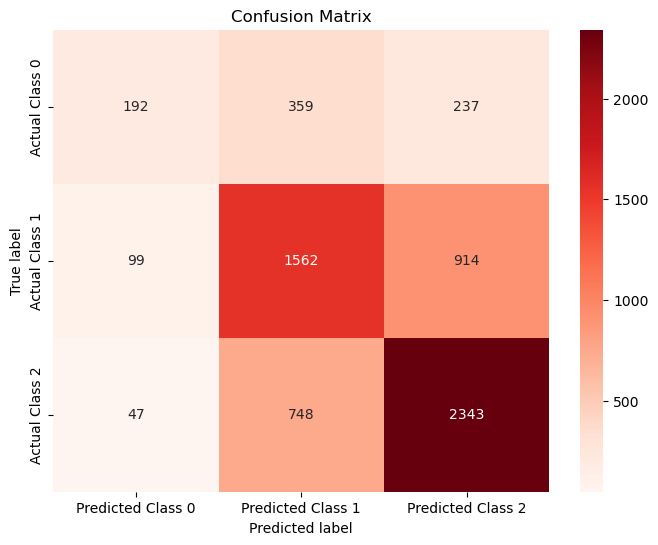

In [11]:
# Make predictions on the test set
y_pred = model.predict(X_test)
num_classes = 3
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a DataFrame for better visualization
conf_matrix_df = pd.DataFrame(conf_matrix, columns=['Predicted Class ' + str(i) for i in range(num_classes)],
                              index=['Actual Class ' + str(i) for i in range(num_classes)])

# Plotting the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, cmap='Reds', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()